In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

/home/jgauthie/om2/miniconda/envs/huggingface/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
suites = ["number_prep", "number_src", "number_orc",
          "reflexive_src_fem", "reflexive_src_masc",
          "reflexive_orc_fem", "reflexive_orc_masc",
          "reflexive_prep_fem", "reflexive_prep_masc",
          "subordination_src-src", "subordination_orc-orc", "subordination_pp-pp",
          "mvrr"]

In [56]:
# Format: suite_first_token -> [((expected_grammatical_region, expected_grammatical_condition),
#                                (expected_ungrammatical_region, expected_ungrammatical_condition), ...]
# 
# Will be used to compute margins between region-condition values.

margin_measures = {
    "fgd_pp": [((8, "that_nogap"), (8, "what_nogap")),
               ((9, "what_gap"), (9, "that_gap"))],
    "fgd_subject": [((4, "that_nogap"), (4, "what_nogap")),
                    ((5, "what_gap"), (5, "that_gap"))],
    "fgd_object": [((6, "that_nogap"), (6, "what_nogap")),
                   ((7, "what_gap"), (7, "that_gap"))],
    
    "number_prep": [((7, "match_sing"), (7, "mismatch_sing")),
                    ((7, "match_plural"), (7, "mismatch_plural"))],
    "number_src": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],
    "number_orc": [((8, "match_sing"), (8, "mismatch_sing")),
                   ((8, "match_plural"), (8, "mismatch_plural"))],

    "reflexive_prep_fem": [((8, "match_sing"), (8, "mismatch_sing")),
                           ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_fem": [((9, "match_sing"), (9, "mismatch_sing")),
                          ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_prep_masc": [((8, "match_sing"), (8, "mismatch_sing")),
                            ((8, "match_plural"), (8, "mismatch_plural"))],
    "reflexive_src_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    "reflexive_orc_masc": [((9, "match_sing"), (9, "mismatch_sing")),
                           ((9, "match_plural"), (9, "mismatch_plural"))],
    
    "subordination_src-src": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_orc-orc": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                              ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    "subordination_pp-pp": [((6, "no-sub_no-matrix"), (6, "sub_no-matrix")),
                            ((6, "sub_matrix"), (6, "no-sub_matrix"))],
    
    "mvrr": [((6, "unreduced_ambig"), (6, "reduced_ambig")),
             ((6, "reduced_unambig"), (6, "reduced_ambig"))],
}

In [58]:
critical_regions = {suite: set(region for region_comparison in region_comparisons for region in region_comparison)
                    for suite, region_comparisons in margin_measures.items()}
critical_region_strs = {suite: {" ".join(map(str, region)) for region in regions} for suite, regions in critical_regions.items()}
critical_region_strs

{'number_prep': {'7 match_plural',
  '7 match_sing',
  '7 mismatch_plural',
  '7 mismatch_sing'},
 'number_src': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'number_orc': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_prep_fem': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_src_fem': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'reflexive_orc_fem': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'reflexive_prep_masc': {'8 match_plural',
  '8 match_sing',
  '8 mismatch_plural',
  '8 mismatch_sing'},
 'reflexive_src_masc': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'reflexive_orc_masc': {'9 match_plural',
  '9 match_sing',
  '9 mismatch_plural',
  '9 mismatch_sing'},
 'subordination_src-src': {'6 no-sub_matrix',
  '6 no-sub_no-matrix',
  '6 sub_

In [5]:
sns.set_context("talk")

## Prediction results

In [6]:
prediction_dfs = [pd.read_csv(f"{suite}.predictions.csv") for suite in suites]
prediction_df = pd.concat(prediction_dfs, names=["suite"], keys=suites)
prediction_df["first_item"] = prediction_df.used_item_numbers.str.split().str.get(0)

canonical_suite = {suite_name: next(can_suite for can_suite in critical_regions.keys()
                                    if can_suite in suite_name)
                   for suite_name in set(prediction_df.index.get_level_values("suite"))}

prediction_df["canonical_suite"] = prediction_df.index.get_level_values("suite").map(canonical_suite)
prediction_df["suite_category"] = prediction_df.canonical_suite.str.split("_").apply(lambda parts: "_".join(parts[:-1]) if len(parts) > 1 else parts[0])
prediction_df["critical_region"] = prediction_df.canonical_suite.map(critical_regions)

prediction_df["num_prefix_sentences"] = prediction_df.used_conditions.str.count(" ").fillna(0)
prediction_df["prefix_length_bin"] = pd.cut(prediction_df.prefix_length, 20).astype(str)

prediction_df

Unnamed: 0  item_number  prediction_0  prediction_1  \
suite                                                                   
number_prep 0              0            1          True          True   
            1              1            2          True         False   
            2              2            3         False         False   
            3              3            4          True         False   
            4              4            5         False          True   
...                      ...          ...           ...           ...   
mvrr        2483        2483         2484          True         False   
            2484        2484         2485          True          True   
            2485        2485         2486         False         False   
            2486        2486         2487          True          True   
            2487        2487         2488          True          True   

                                                  used_item_numbers  \
suite                                                                 
number_prep 0                                                     1   
            1                                                     2   
            2                                                     3   
            3                                                     4   
            4                                                     5   
...                                                             ...   
mvrr        2483  4 19 6 21 5 21 23 27 12 16 24 24 15 23 3 11 26...   
            2484  19 4 7 21 4 16 23 19 14 13 28 11 13 4 7 26 20 ...   
            2485  3 12 1 4 17 14 11 21 2 25 16 9 22 28 21 9 28 2...   
            2486  3 10 15 25 28 20 14 14 4 23 23 12 7 5 28 24 27...   
            2487  2 17 19 13 10 28 25 1 26 19 20 3 25 9 3 12 21 ...   

                                                    used_conditions  \
suite                                                                 
number_prep 0                                                   NaN   
            1                                                   NaN   
            2                                                   NaN   
            3                                                   NaN   
            4                                                   NaN   
...                                                             ...   
mvrr        2483  reduced_unambig unreduced_ambig unreduced_ambi...   
            2484  reduced_ambig reduced_ambig reduced_ambig redu...   
            2485  unreduced_unambig reduced_ambig reduced_unambi...   
            2486  unreduced_unambig reduced_ambig reduced_unambi...   
            2487  unreduced_ambig unreduced_unambig unreduced_am...   

                  prefix_length prediction_2 first_item canonical_suite  \
suite                                                                     
number_prep 0                 0          NaN          1     number_prep   
            1                 0          NaN          2     number_prep   
            2                 0          NaN          3     number_prep   
            3                 0          NaN          4     number_prep   
            4                 0          NaN          5     number_prep   
...                         ...          ...        ...             ...   
mvrr        2483            499        False          4            mvrr   
            2484            492         True         19            mvrr   
            2485            484         True          3            mvrr   
            2486            484         True          3            mvrr   
            2487            497         True          2            mvrr   

                 suite_category  critical_region  num_prefix_sentences  \
suite                                                                    
number_prep 0            number                7                   0.0   
            1         

In [7]:
# Store basic representation of first item of each suite
basic_suite_df = prediction_df[prediction_df.prefix_length == 0].groupby("canonical_suite").first()
basic_suite_df

Unnamed: 0  item_number  prediction_0  prediction_1  \
canonical_suite                                                              
mvrr                            0            1          True          True   
number_orc                      0            1          True          True   
number_prep                     0            1          True          True   
number_src                      0            1          True          True   
reflexive_orc_fem               0            1         False          True   
reflexive_orc_masc              0            1          True          True   
reflexive_prep_fem              0            1         False          True   
reflexive_prep_masc             0            1          True          True   
reflexive_src_fem               0            1         False          True   
reflexive_src_masc              0            1          True          True   
subordination_orc-orc           0            1          True          True   
subordination_pp-pp             0            1          True          True   
subordination_src-src           0            1          True          True   

                      used_item_numbers used_conditions  prefix_length  \
canonical_suite                                                          
mvrr                                  1            None              0   
number_orc                            1            None              0   
number_prep                           1            None              0   
number_src                            1            None              0   
reflexive_orc_fem                     1            None              0   
reflexive_orc_masc                    1            None              0   
reflexive_prep_fem                    1            None              0   
reflexive_prep_masc                   1            None              0   
reflexive_src_fem                     1            None              0   
reflexive_src_masc                    1            None              0   
subordination_orc-orc                 1            None              0   
subordination_pp-pp                   1            None              0   
subordination_src-src                 1            None              0   

                      prediction_2 first_item  suite_category  \
canonical_suite                                                 
mvrr                          True          1            mvrr   
number_orc                    None          1          number   
number_prep                   None          1          number   
number_src                    None          1          number   
reflexive_orc_fem             None          1   reflexive_orc   
reflexive_orc_masc            None          1   reflexive_orc   
reflexive_prep_fem            None          1  reflexive_prep   
reflexive_prep_masc           None          1  reflexive_prep   
reflexive_src_fem             None          1   reflexive_src   
reflexive_src_masc            None          1   reflexive_src   
subordination_orc-orc         None          1   subordination   
subordination_pp-pp           None          1   subordination   
subordination_src-src         None          1   subordination   

                       critical_region  num_prefix_sentences prefix_length_bin  
canonical_suite                                                                 
mvrr                                 6                   0.0   (-0.527, 26.35]  
number_orc                           8                   0.0   (-0.527, 26.35]  
number_prep                          7                   0.0   (-0.527, 26.35]  
number_src                           8                   0.0   (-0.527, 26.35]  
reflexive_orc_fem                    9                   0.0   (-0.527, 26.35]  
reflexive_orc_masc                   9                   0.0   (-0.527, 26.35]  
reflexive_prep_fem                   8                   0.0   (-0.527, 26.35]  
reflexive_prep_masc                 

In [8]:
# Get baseline accuracy results.
prediction_df[prediction_df.used_conditions.isna()] \
    [[col for col in prediction_df if col.startswith("prediction_") or col == "canonical_suite"]] \
    .melt(id_vars=["canonical_suite"]).groupby(["canonical_suite", "variable"]).value.mean().dropna()

canonical_suite        variable    
mvrr                   prediction_0    1.000000
                       prediction_1    0.892857
                       prediction_2    0.857143
number_orc             prediction_0    0.631579
                       prediction_1    0.473684
number_prep            prediction_0    0.789474
                       prediction_1    0.526316
number_src             prediction_0    0.842105
                       prediction_1    0.473684
reflexive_orc_fem      prediction_0    0.473684
                       prediction_1    1.000000
reflexive_orc_masc     prediction_0    0.842105
                       prediction_1    0.947368
reflexive_prep_fem     prediction_0    0.210526
                       prediction_1    1.000000
reflexive_prep_masc    prediction_0    0.894737
                       prediction_1    0.894737
reflexive_src_fem      prediction_0    0.157895
                       prediction_1    1.000000
reflexive_src_masc     prediction_0    0.684211
    

<AxesSubplot:xlabel='prefix_length', ylabel='Count'>

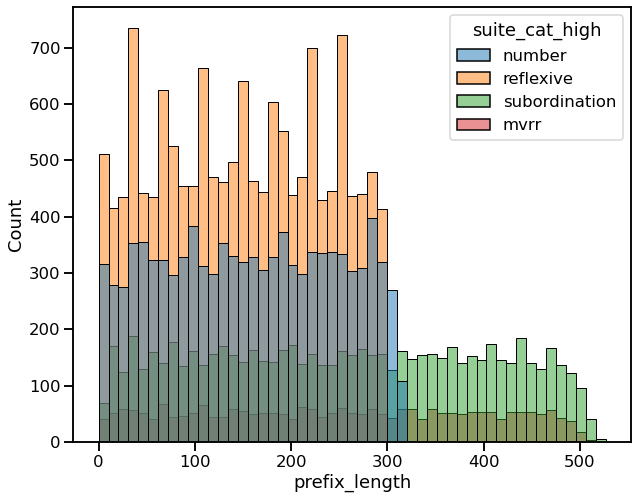

In [9]:
plt.subplots(figsize=(10, 8))
sns.histplot(data=prediction_df.assign(suite_cat_high=prediction_df.suite_category.str.split("_").str[0]), x="prefix_length", hue="suite_cat_high")

In [10]:
prediction_df_melt = prediction_df.reset_index()
meta_vars = ["num_prefix_sentences", "prefix_length", "prefix_length_bin", "canonical_suite", "suite_category", "item_number"]
prediction_df_melt = prediction_df_melt.loc[:, prediction_df_melt.columns.str.startswith(("prediction",) + tuple(meta_vars))] \
    .melt(id_vars=meta_vars, var_name="prediction", value_name="correct")
prediction_df_melt

num_prefix_sentences  prefix_length prefix_length_bin canonical_suite  \
0                        0.0              0   (-0.527, 26.35]     number_prep   
1                        0.0              0   (-0.527, 26.35]     number_prep   
2                        0.0              0   (-0.527, 26.35]     number_prep   
3                        0.0              0   (-0.527, 26.35]     number_prep   
4                        0.0              0   (-0.527, 26.35]     number_prep   
...                      ...            ...               ...             ...   
103444                  40.0            499   (474.3, 500.65]            mvrr   
103445                  40.0            492   (474.3, 500.65]            mvrr   
103446                  40.0            484   (474.3, 500.65]            mvrr   
103447                  40.0            484   (474.3, 500.65]            mvrr   
103448                  40.0            497   (474.3, 500.65]            mvrr   

       suite_category  item_number    prediction correct  
0              number            1  prediction_0    True  
1              number            2  prediction_0    True  
2              number            3  prediction_0   False  
3              number            4  prediction_0    True  
4              number            5  prediction_0   False  
...               ...          ...           ...     ...  
103444           mvrr         2484  prediction_2   False  
103445           mvrr         2485  prediction_2    True  
103446           mvrr         2486  prediction_2    True  
103447           mvrr         2487  prediction_2    True  
103448           mvrr         2488  prediction_2    True  

[103449 rows x 8 columns]

Text(43.04007421875001, 0.5, 'Prediction accuracy')

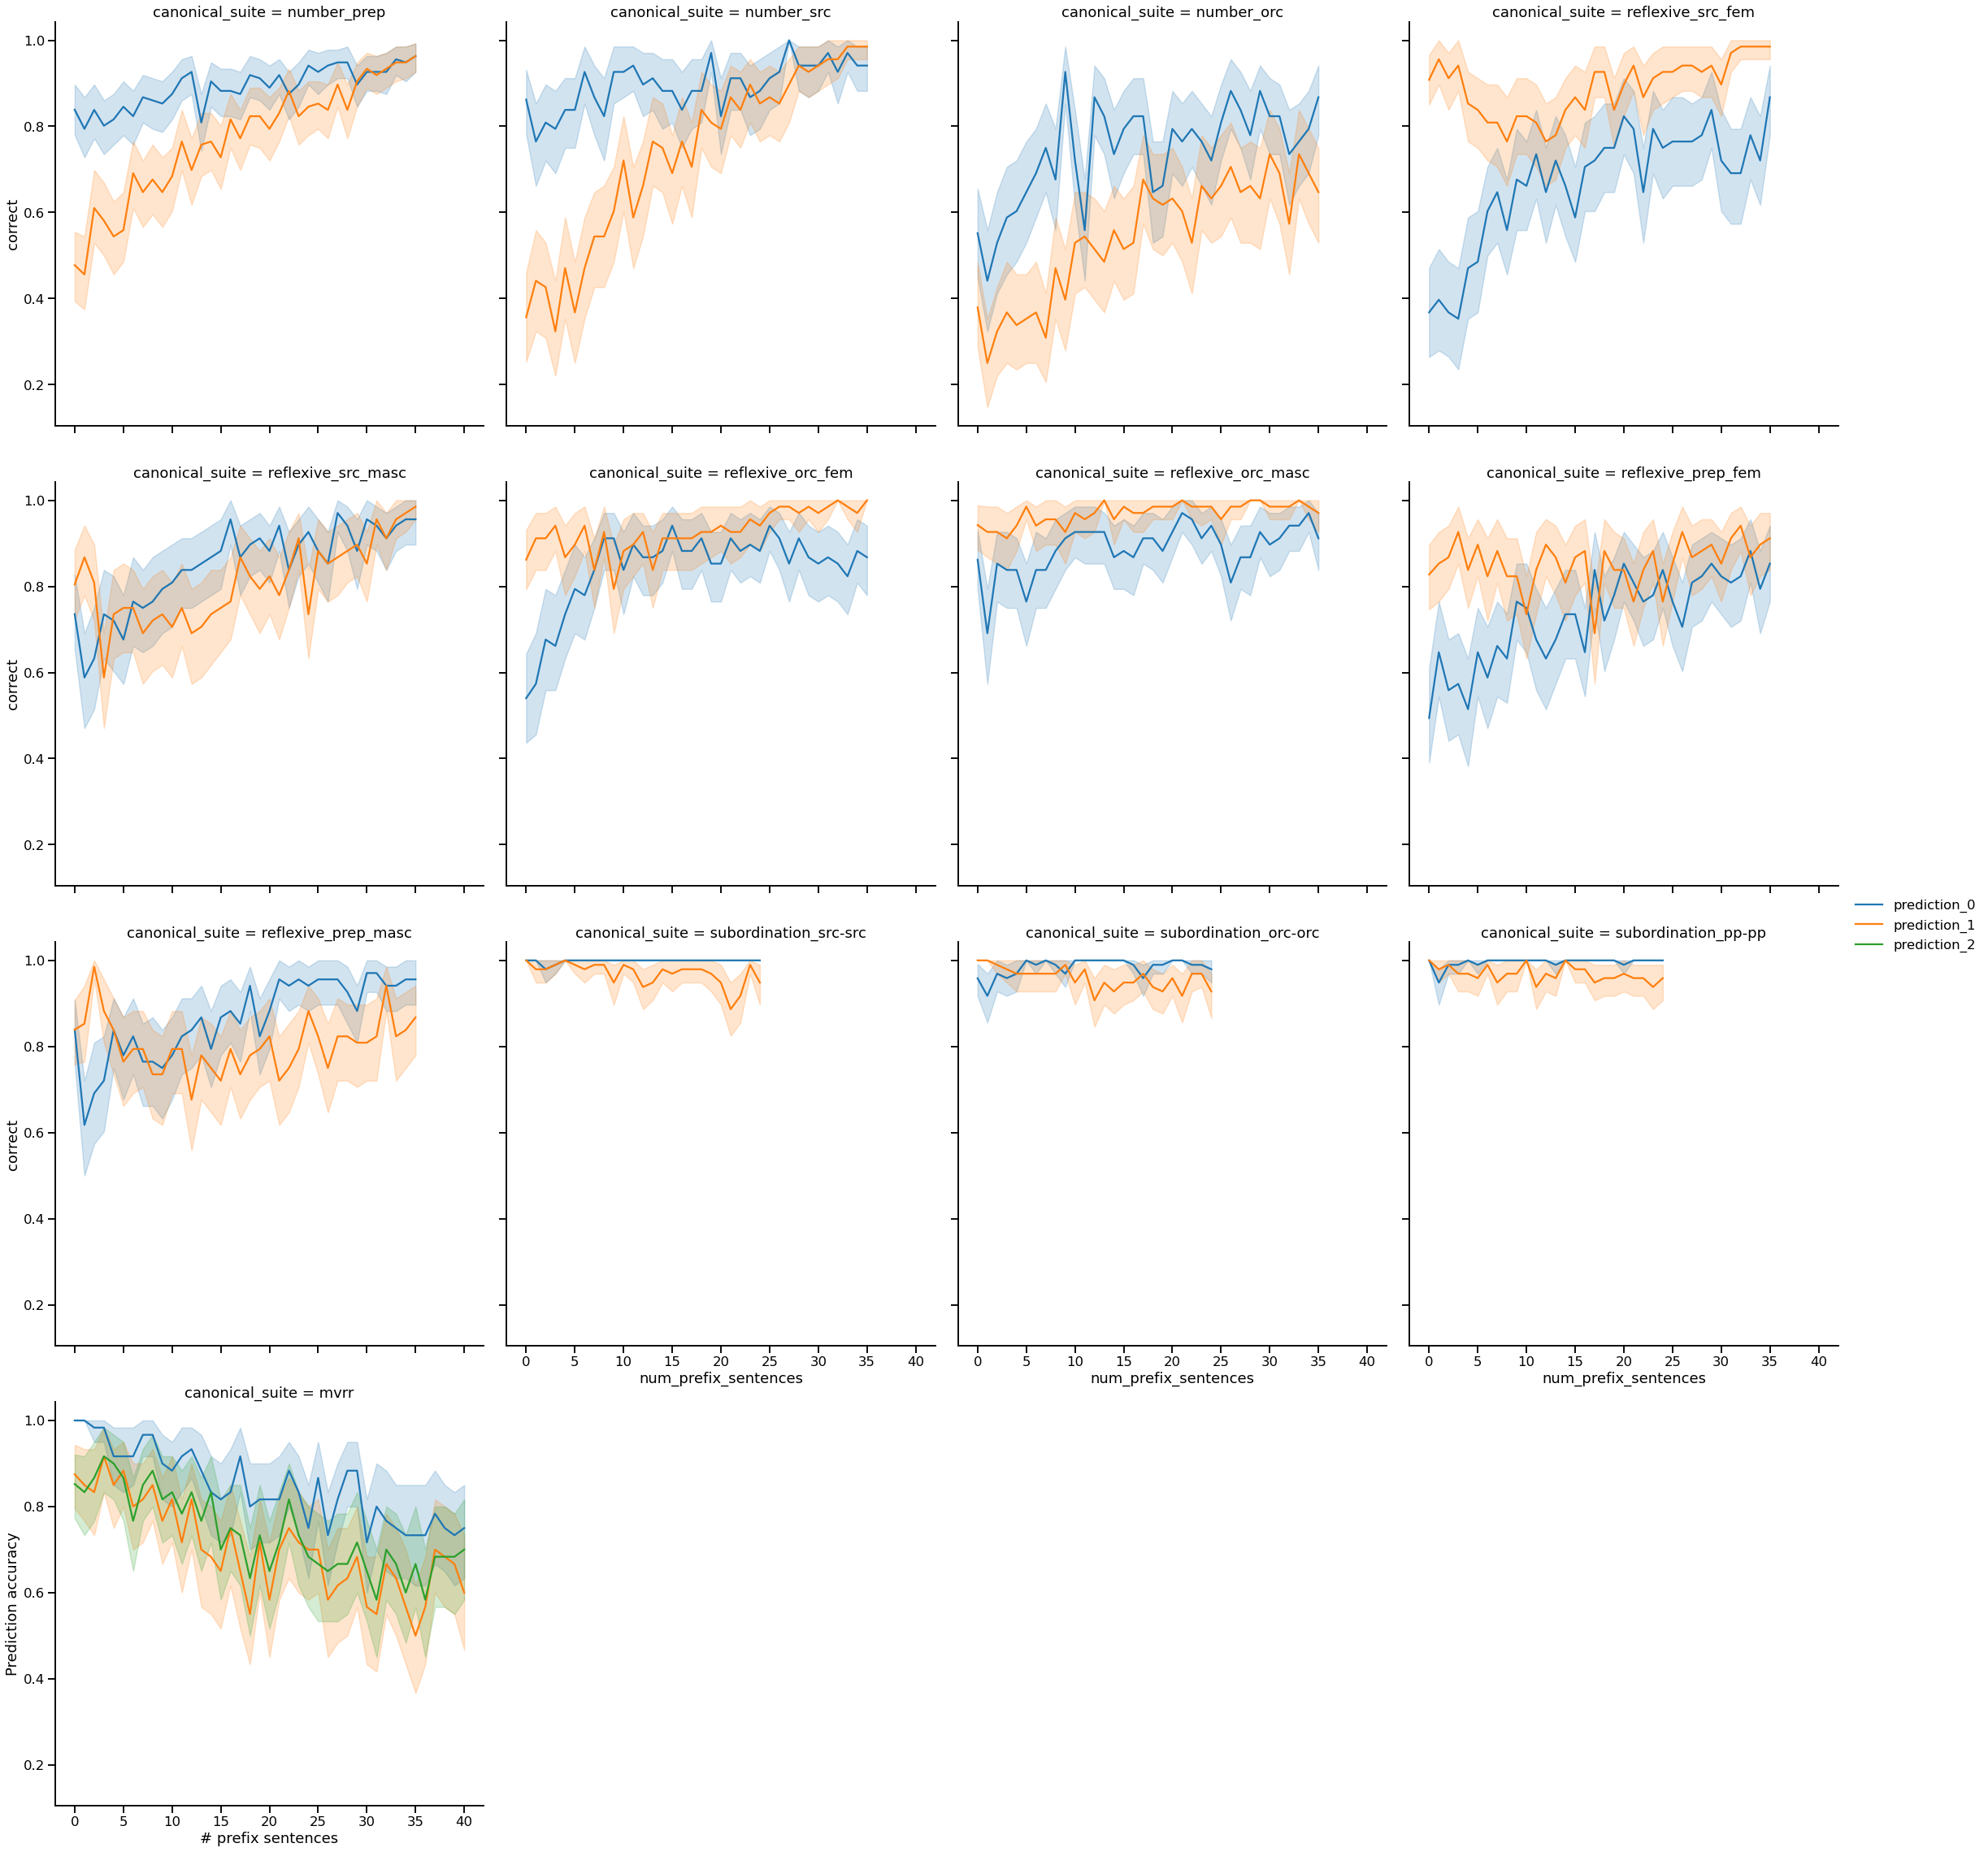

In [11]:
# TODO check conjunction of predictions

g = sns.FacetGrid(data=prediction_df_melt, height=8, col="canonical_suite", col_wrap=4)
g.map(sns.lineplot, "num_prefix_sentences", "correct", "prediction")
g.add_legend()

plt.xlabel("# prefix sentences")
plt.ylabel("Prediction accuracy")

In [12]:
# Too noisy. Use binned plot instead.
# sns.lineplot(data=prediction_df, x="prefix_length", y="prediction_0")

# plt.xlabel("# prefix tokens")
# plt.ylabel("Prediction accuracy")

/tmp/ipykernel_4637/2020521817.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")


Text(43.04007421875001, 0.5, 'Prediction accuracy')

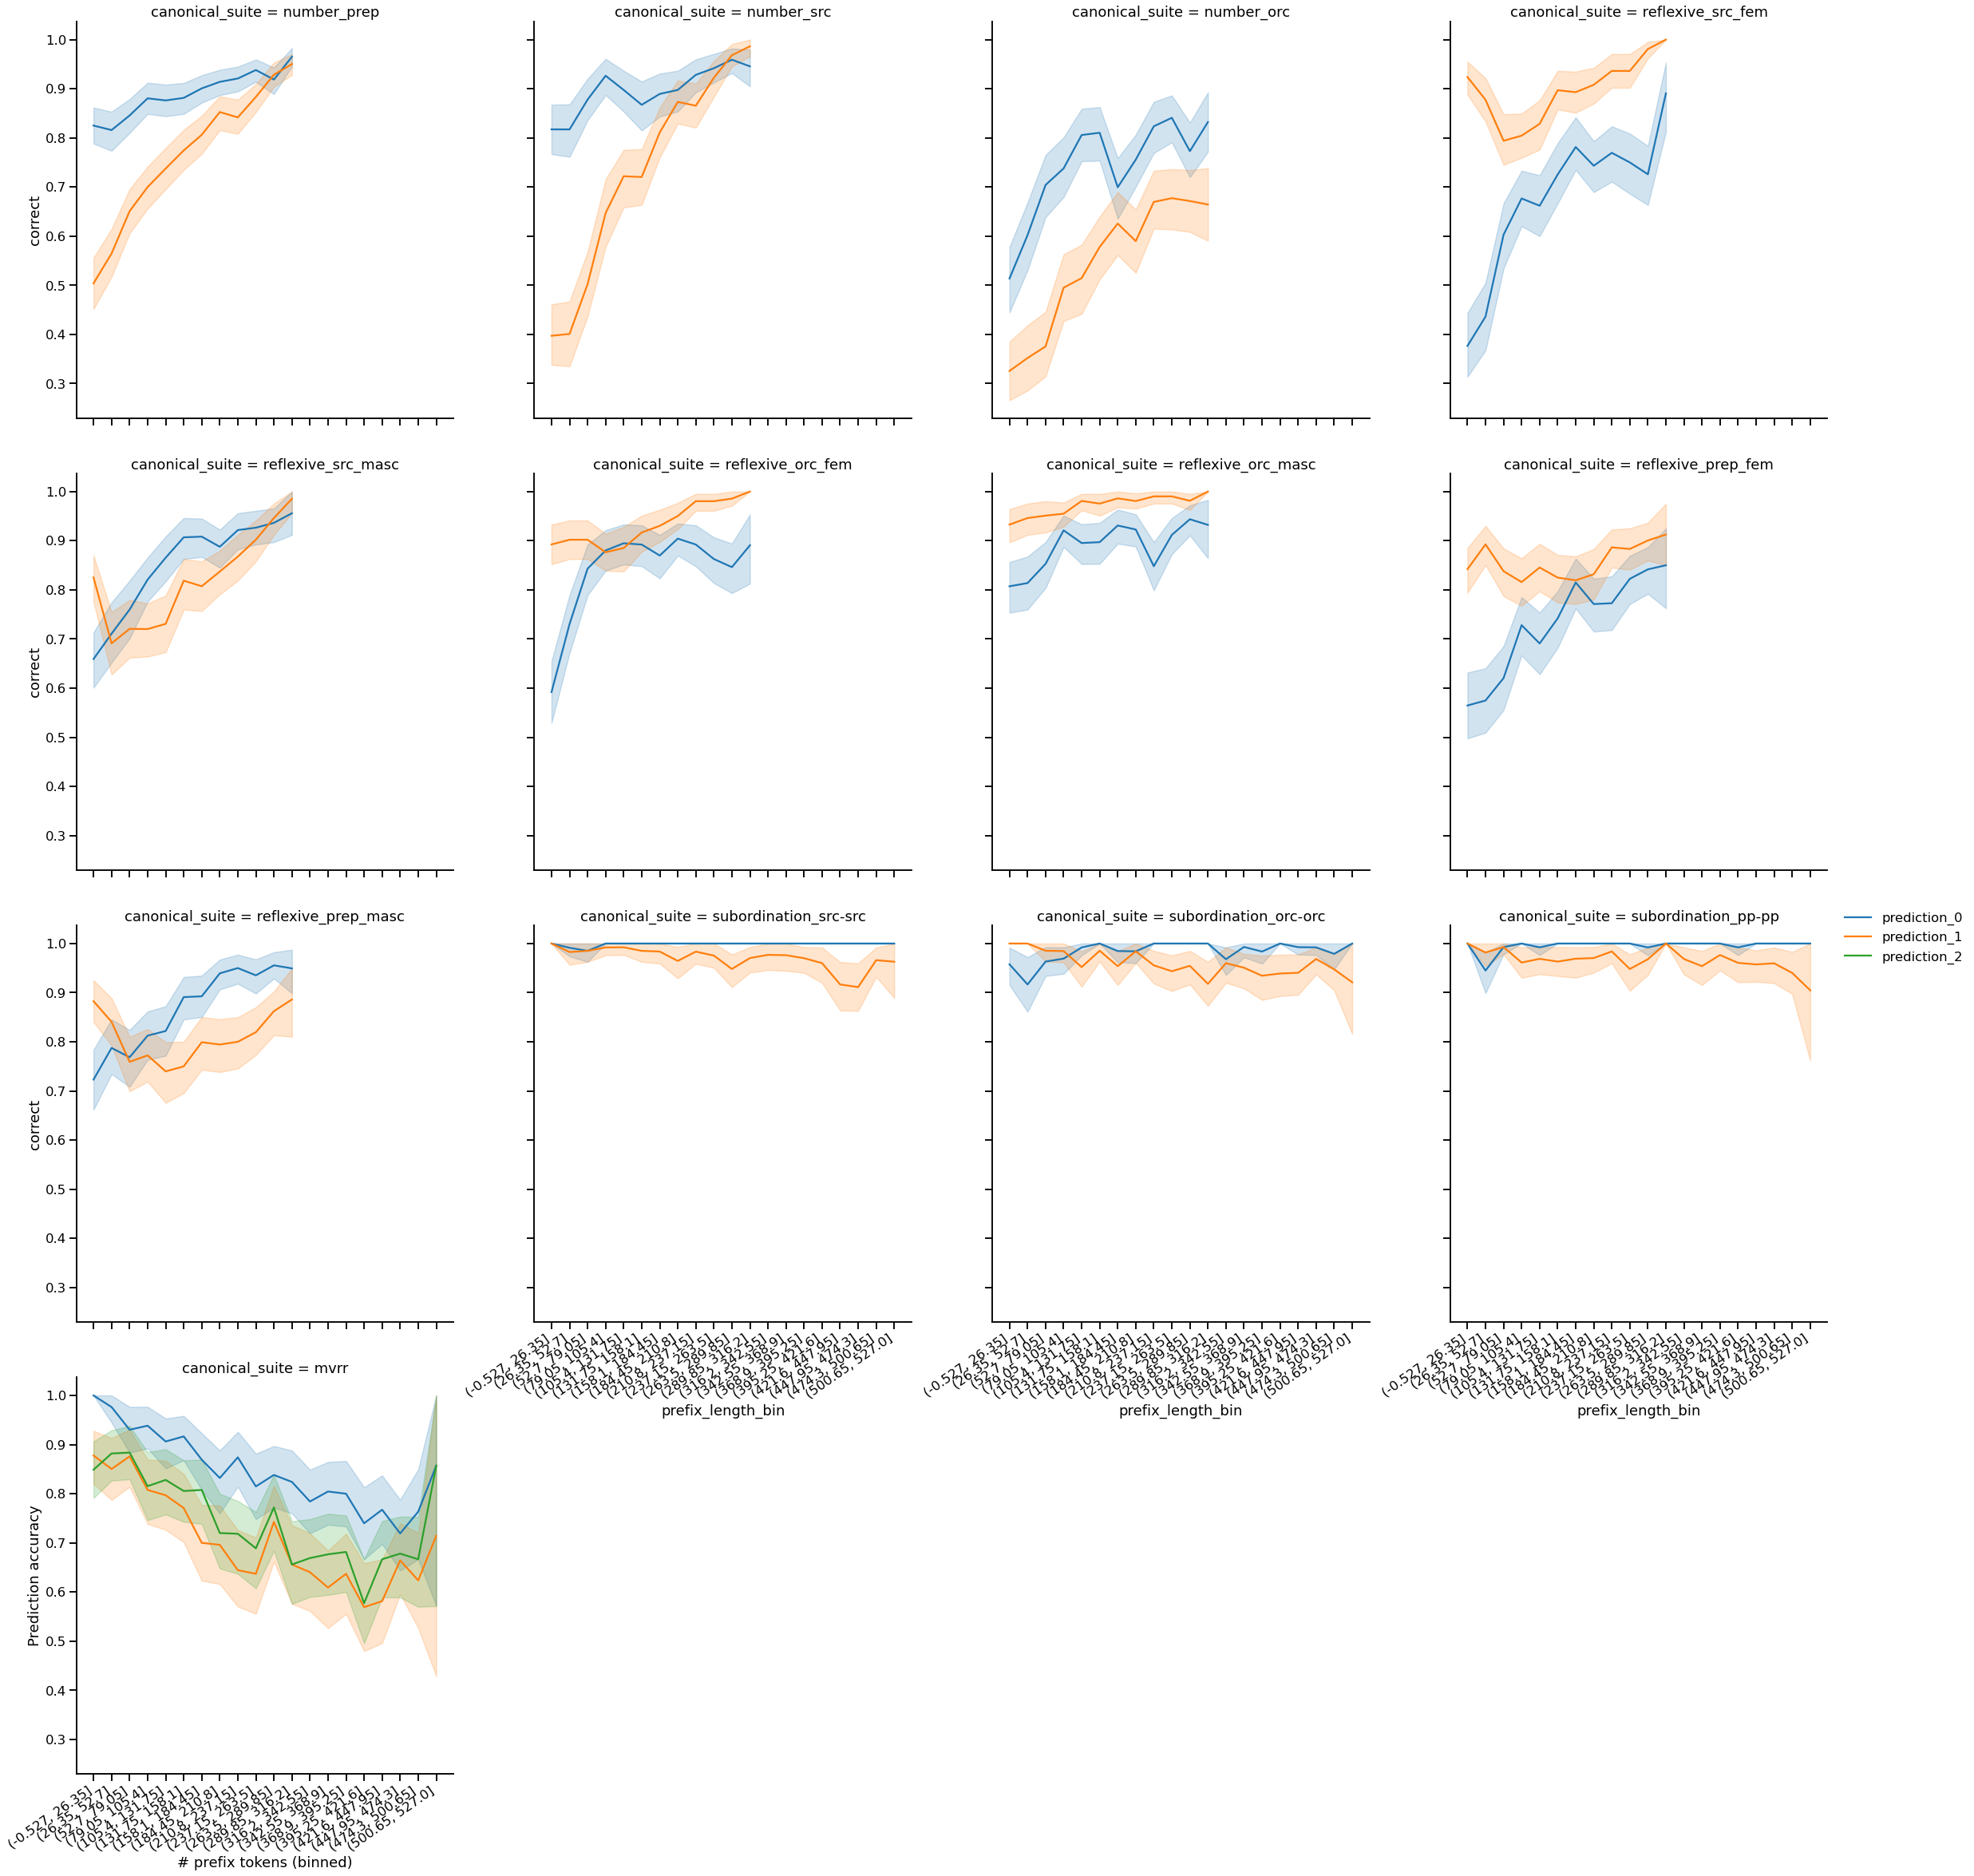

In [31]:
g = sns.FacetGrid(data=prediction_df_melt, height=8, col="canonical_suite", col_wrap=4)
g.map(sns.lineplot, "prefix_length_bin", "correct", "prediction")
g.add_legend()

for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right")

plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Prediction accuracy")

## Margins

In [14]:
region_dfs = [pd.read_csv(f"{suite}.regions.csv") for suite in suites]
region_df = pd.concat(region_dfs, names=["suite"], keys=suites).reset_index()
# Bring in metadata from predictions df
region_df = pd.merge(region_df.reset_index(), prediction_df[meta_vars].reset_index(),
                     on=["suite", "item_number"])

region_df

index        suite  level_1_x  item_number        value  \
0              0  number_prep          0            1    12.441164   
1           4915  number_prep       4915            1    25.171421   
2           9830  number_prep       9830            1     3.329726   
3          14745  number_prep      14745            1    16.262009   
4          19660  number_prep      19660            1     4.061763   
...          ...          ...        ...          ...          ...   
1093955  1084007         mvrr      59711         2488     0.105543   
1093956  1086495         mvrr      62199         2488  2330.677002   
1093957  1088983         mvrr      64687         2488     0.105543   
1093958  1091471         mvrr      67175         2488  2330.677002   
1093959  1093959         mvrr      69663         2488     0.105542   

                 condition  region_number  level_1_y  num_prefix_sentences  \
0               match_sing              3          0                   0.0   
1               match_sing              4          0                   0.0   
2               match_sing              5          0                   0.0   
3               match_sing              6          0                   0.0   
4               match_sing              7          0                   0.0   
...                    ...            ...        ...                   ...   
1093955    unreduced_ambig              2       2487                  40.0   
1093956    reduced_unambig              1       2487                  40.0   
1093957    reduced_unambig              2       2487                  40.0   
1093958  unreduced_unambig              1       2487                  40.0   
1093959  unreduced_unambig              2       2487                  40.0   

         prefix_length prefix_length_bin canonical_suite suite_category  
0                    0   (-0.527, 26.35]     number_prep         number  
1                    0   (-0.527, 26.35]     number_prep         number  
2                    0   (-0.527, 26.35]     number_prep         number  
3                    0   (-0.527, 26.35]     number_prep         number  
4                    0   (-0.527, 26.35]     number_prep         number  
...                ...               ...             ...            ...  
1093955            497   (474.3, 500.65]            mvrr           mvrr  
1093956            497   (474.3, 500.65]            mvrr           mvrr  
1093957            497   (474.3, 500.65]            mvrr           mvrr  
1093958            497   (474.3, 500.65]            mvrr           mvrr  
1093959            497   (474.3, 500.65]            mvrr           mvrr  

[1093960 rows x 13 columns]

In [45]:
_, df = next(iter(region_df.groupby(["suite"])))
df.region_number.astype(str).str.cat(df.condition, " ").isin(critical_region_strs["mvrr"])

1024296    False
1024297    False
1024298    False
1024299     True
1024300    False
           ...  
1093955    False
1093956    False
1093957    False
1093958    False
1093959    False
Name: region_number, Length: 69664, dtype: bool

In [49]:
def filter_critical_regions(suite_df):
    critical_strs = critical_region_strs[suite_df.canonical_suite.iloc[0]]
    is_critical = suite_df.region_number.astype(str).str.cat(suite_df.condition, " ").isin(critical_strs)
    return suite_df[is_critical]

critical_region_df = region_df.groupby(["suite", "canonical_suite"], as_index=False) \
    .apply(filter_critical_regions)
critical_region_df

index                  suite  level_1_x  item_number      value  \
0  1024299  1031760                   mvrr       7464            1  19.608257   
   1024304  1044200                   mvrr      19904            1  11.639932   
   1024309  1056640                   mvrr      32344            1  11.770083   
   1024327  1031761                   mvrr       7465            2  17.263639   
   1024332  1044201                   mvrr      19905            2  10.611015   
...             ...                    ...        ...          ...        ...   
12 906763    896998  subordination_src-src      48958         2447  11.311989   
   906772    860279  subordination_src-src      12239         2448   6.276355   
   906777    872519  subordination_src-src      24479         2448   4.079598   
   906782    884759  subordination_src-src      36719         2448  29.245785   
   906787    896999  subordination_src-src      48959         2448  36.252571   

                   condition  region_number  level_1_y  num_prefix_sentences  \
0  1024299     reduced_ambig              6          0                   0.0   
   1024304   unreduced_ambig              6          0                   0.0   
   1024309   reduced_unambig              6          0                   0.0   
   1024327     reduced_ambig              6          1                   0.0   
   1024332   unreduced_ambig              6          1                   0.0   
...                      ...            ...        ...                   ...   
12 906763      no-sub_matrix              6       2446                  24.0   
   906772      sub_no-matrix              6       2447                  24.0   
   906777   no-sub_no-matrix              6       2447                  24.0   
   906782         sub_matrix              6       2447                  24.0   
   906787      no-sub_matrix              6       2447                  24.0   

            prefix_length prefix_length_bin        canonical_suite  \
0  1024299              0   (-0.527, 26.35]                   mvrr   
   1024304              0   (-0.527, 26.35]                   mvrr   
   1024309              0   (-0.527, 26.35]                   mvrr   
   1024327              0   (-0.527, 26.35]                   mvrr   
   1024332              0   (-0.527, 26.35]                   mvrr   
...                   ...               ...                    ...   
12 906763             509   (500.65, 527.0]  subordination_src-src   
   906772             492   (474.3, 500.65]  subordination_src-src   
   906777             492   (474.3, 500.65]  subordination_src-src   
   906782             492   (474.3, 500.65]  subordination_src-src   
   906787             492   (474.3, 500.65]  subordination_src-src   

           suite_category  
0  1024299           mvrr  
   1024304           mvrr  
   1024309           mvrr  
   1024327           mvrr  
   1024332           mvrr  
...                   ...  
12 906763   subordination  
   906772   subordination  
   906777   subordination  
   906782   subordination  
   906787   subordination  

[135444 rows x 13 columns]

Text(20.690000000000012, 0.5, 'Raw surprisal')

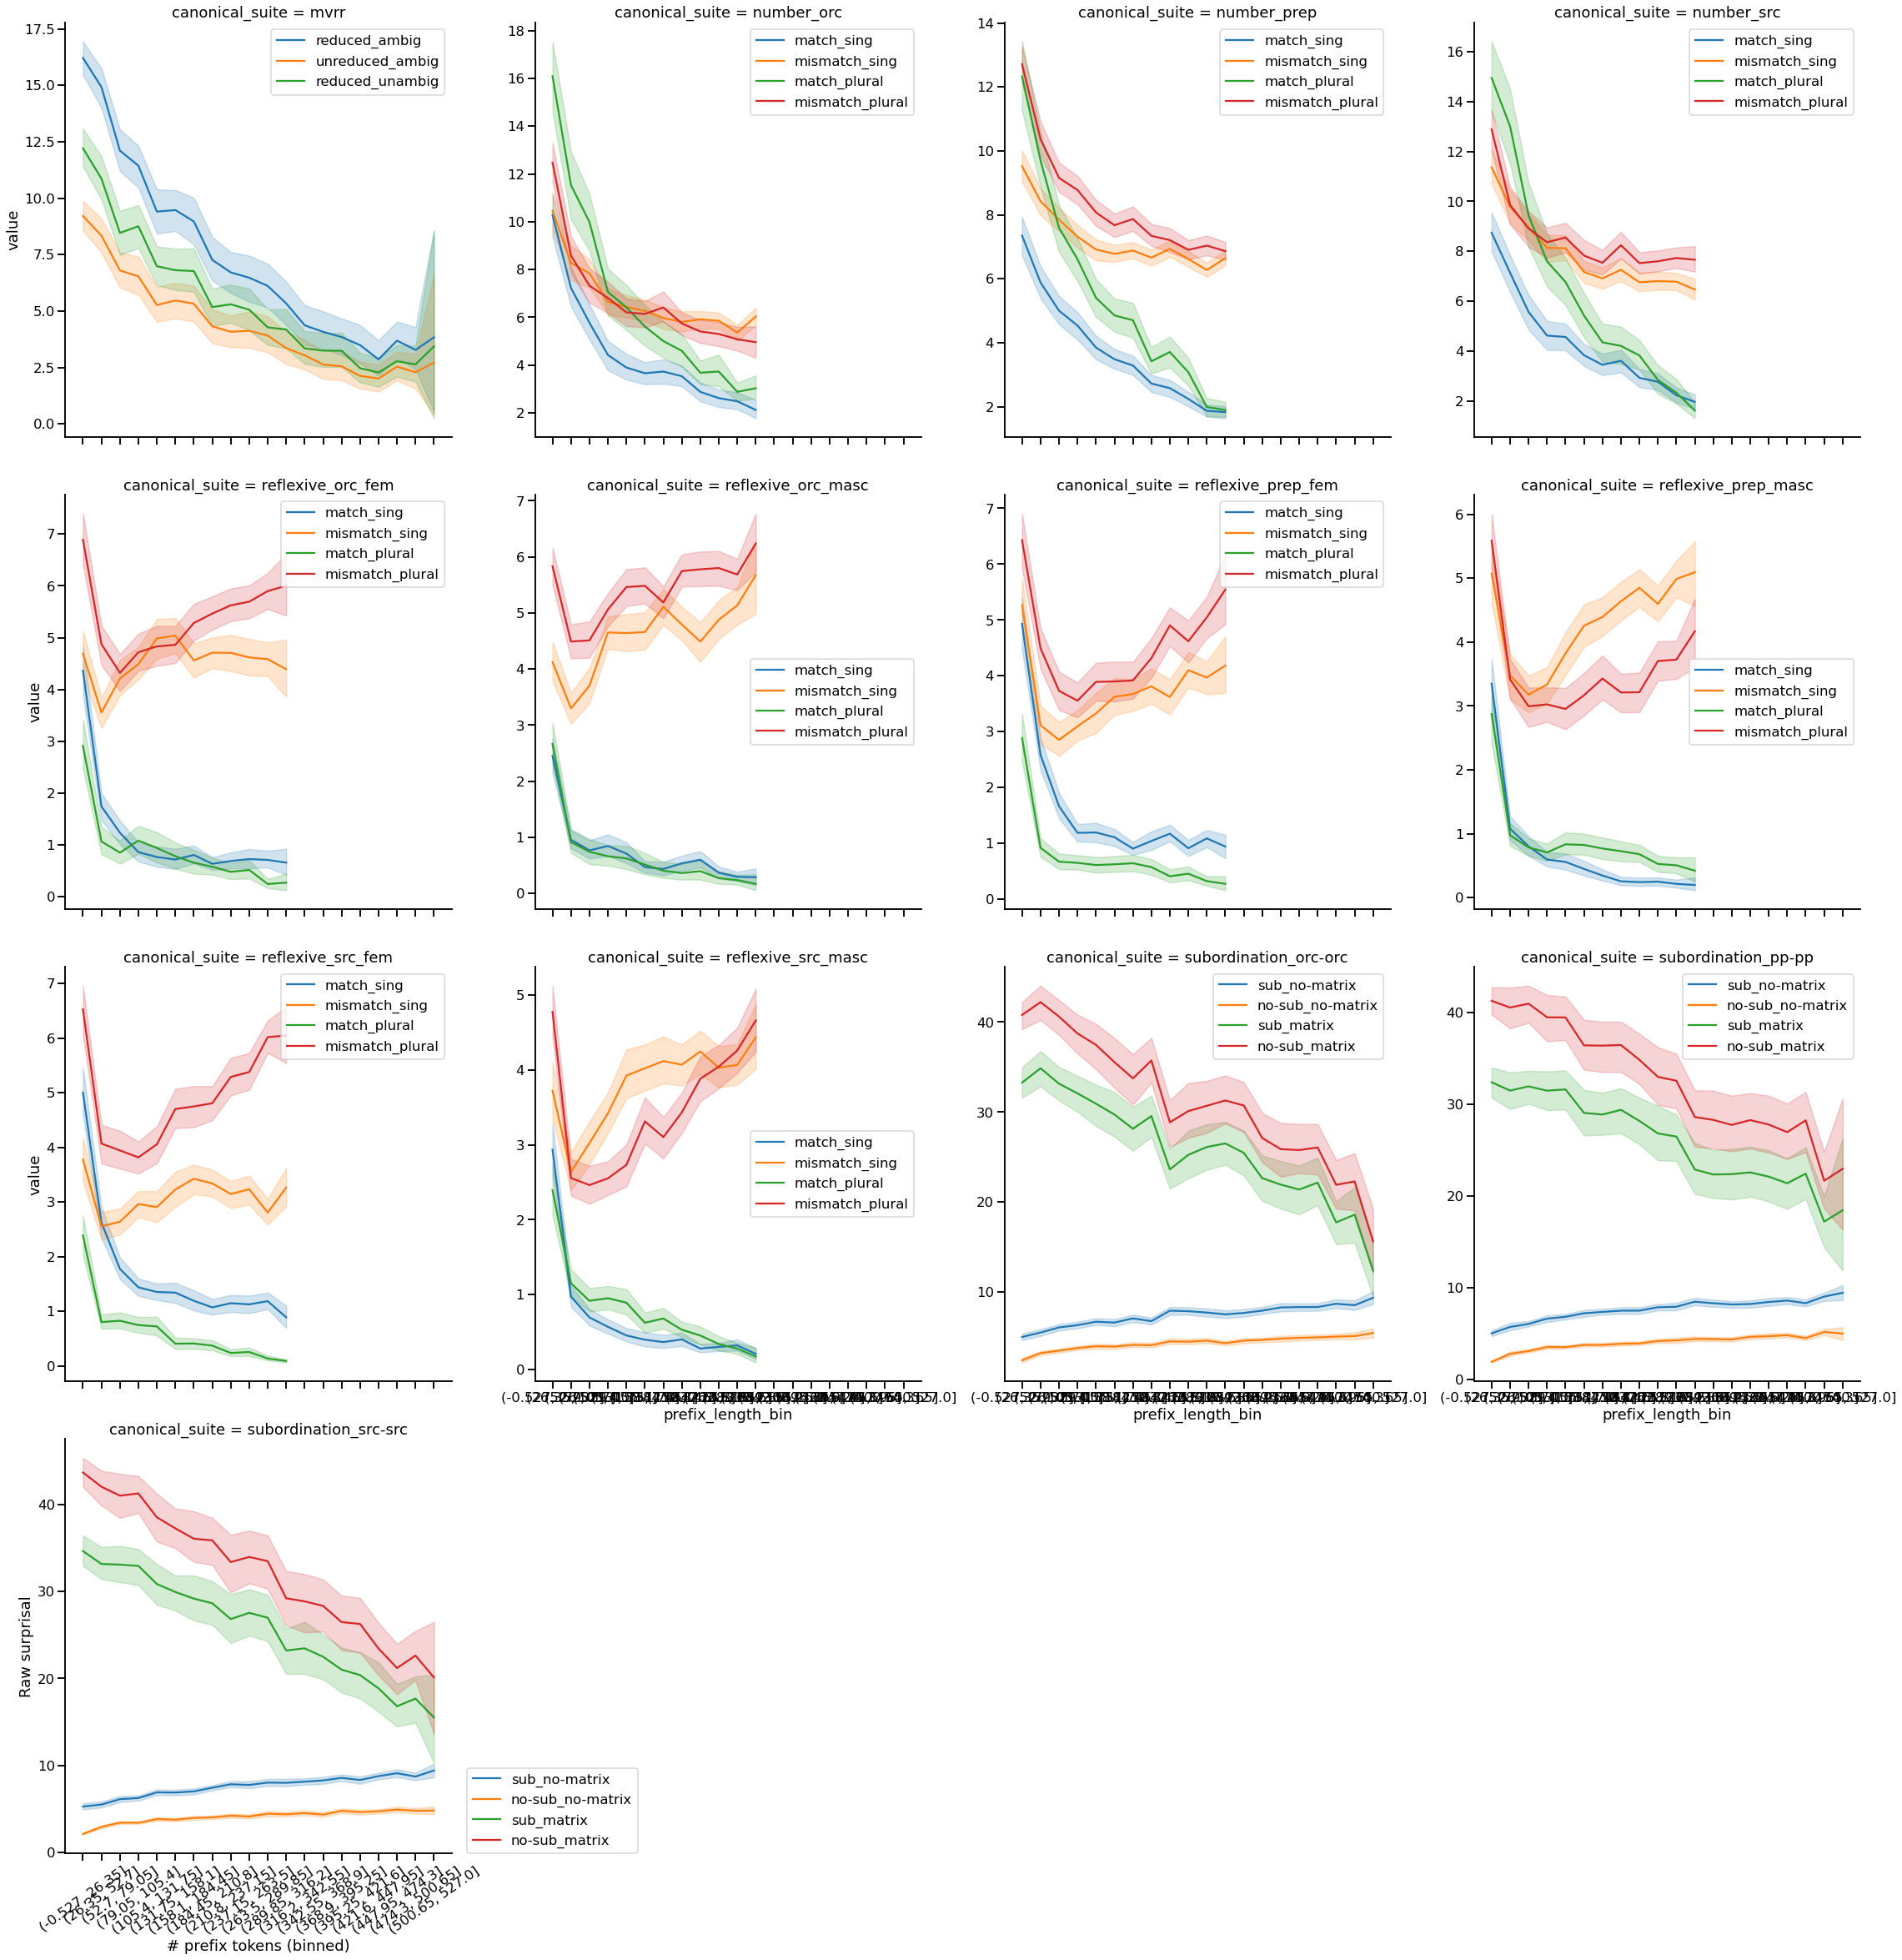

In [50]:
g = sns.FacetGrid(data=critical_region_df, height=8, col="canonical_suite", col_wrap=4, sharey=False)
g.map(sns.lineplot, "prefix_length_bin", "value", "condition")
for ax in g.axes.ravel():
    ax.legend()

plt.xticks(rotation=35)
plt.legend(loc=(1.04,0))
plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Raw surprisal")

In [17]:
# g = sns.catplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", alpha=0.1,
#                 height=10)
# sns.lineplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", ax=g.ax, legend=False)

# plt.legend(loc=(1.04,0))
# plt.xlabel("# prefix sentences")
# plt.ylabel("Raw surprisal")

In [59]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["region_number", "condition"]).value
    
    margins = pd.Series([rows.loc[ungrammatical] - rows.loc[grammatical]
                         for grammatical, ungrammatical in margin_spec])
    return margins

margin_sizes = critical_region_df.groupby(["suite", "item_number"]).apply(compute_margins)
margin_sizes

0         1
suite                 item_number                     
mvrr                  1             7.968326  7.838174
                      2             6.652624  6.709243
                      3             4.301697  2.804442
                      4            10.445646  0.187893
                      5             4.104117  0.000000
...                                      ...       ...
subordination_src-src 2444          4.818648  1.824209
                      2445          4.321604  6.364243
                      2446          3.327927  6.469498
                      2447          7.665365  4.715309
                      2448          2.196756  7.006786

[34483 rows x 2 columns]

In [60]:
margin_sizes = pd.merge(margin_sizes.reset_index(), prediction_df[meta_vars].reset_index(),
                        on=["suite", "item_number"])
margin_sizes

suite  item_number          0         1  level_1  \
0                       mvrr            1   7.968326  7.838174        0   
1                       mvrr            2   6.652624  6.709243        1   
2                       mvrr            3   4.301697  2.804442        2   
3                       mvrr            4  10.445646  0.187893        3   
4                       mvrr            5   4.104117  0.000000        4   
...                      ...          ...        ...       ...      ...   
34478  subordination_src-src         2444   4.818648  1.824209     2443   
34479  subordination_src-src         2445   4.321604  6.364243     2444   
34480  subordination_src-src         2446   3.327927  6.469498     2445   
34481  subordination_src-src         2447   7.665365  4.715309     2446   
34482  subordination_src-src         2448   2.196756  7.006786     2447   

       num_prefix_sentences  prefix_length prefix_length_bin  \
0                       0.0              0   (-0.527, 26.35]   
1                       0.0              0   (-0.527, 26.35]   
2                       0.0              0   (-0.527, 26.35]   
3                       0.0              0   (-0.527, 26.35]   
4                       0.0              0   (-0.527, 26.35]   
...                     ...            ...               ...   
34478                  24.0            509   (500.65, 527.0]   
34479                  24.0            492   (474.3, 500.65]   
34480                  24.0            485   (474.3, 500.65]   
34481                  24.0            509   (500.65, 527.0]   
34482                  24.0            492   (474.3, 500.65]   

             canonical_suite suite_category  
0                       mvrr           mvrr  
1                       mvrr           mvrr  
2                       mvrr           mvrr  
3                       mvrr           mvrr  
4                       mvrr           mvrr  
...                      ...            ...  
34478  subordination_src-src  subordination  
34479  subordination_src-src  subordination  
34480  subordination_src-src  subordination  
34481  subordination_src-src  subordination  
34482  subordination_src-src  subordination  

[34483 rows x 10 columns]

In [61]:
# Prefer binned figure below.

# sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length"], value_vars=["sing", "plur"], var_name="Prediction"),
#              x="prefix_length", y="value", hue="Prediction")

# plt.legend(loc=(1.04, 0))
# plt.axhline(0, color="gray", linestyle="--")
# plt.xlabel("# prefix tokens")
# plt.ylabel("Grammaticality margin (bits)")

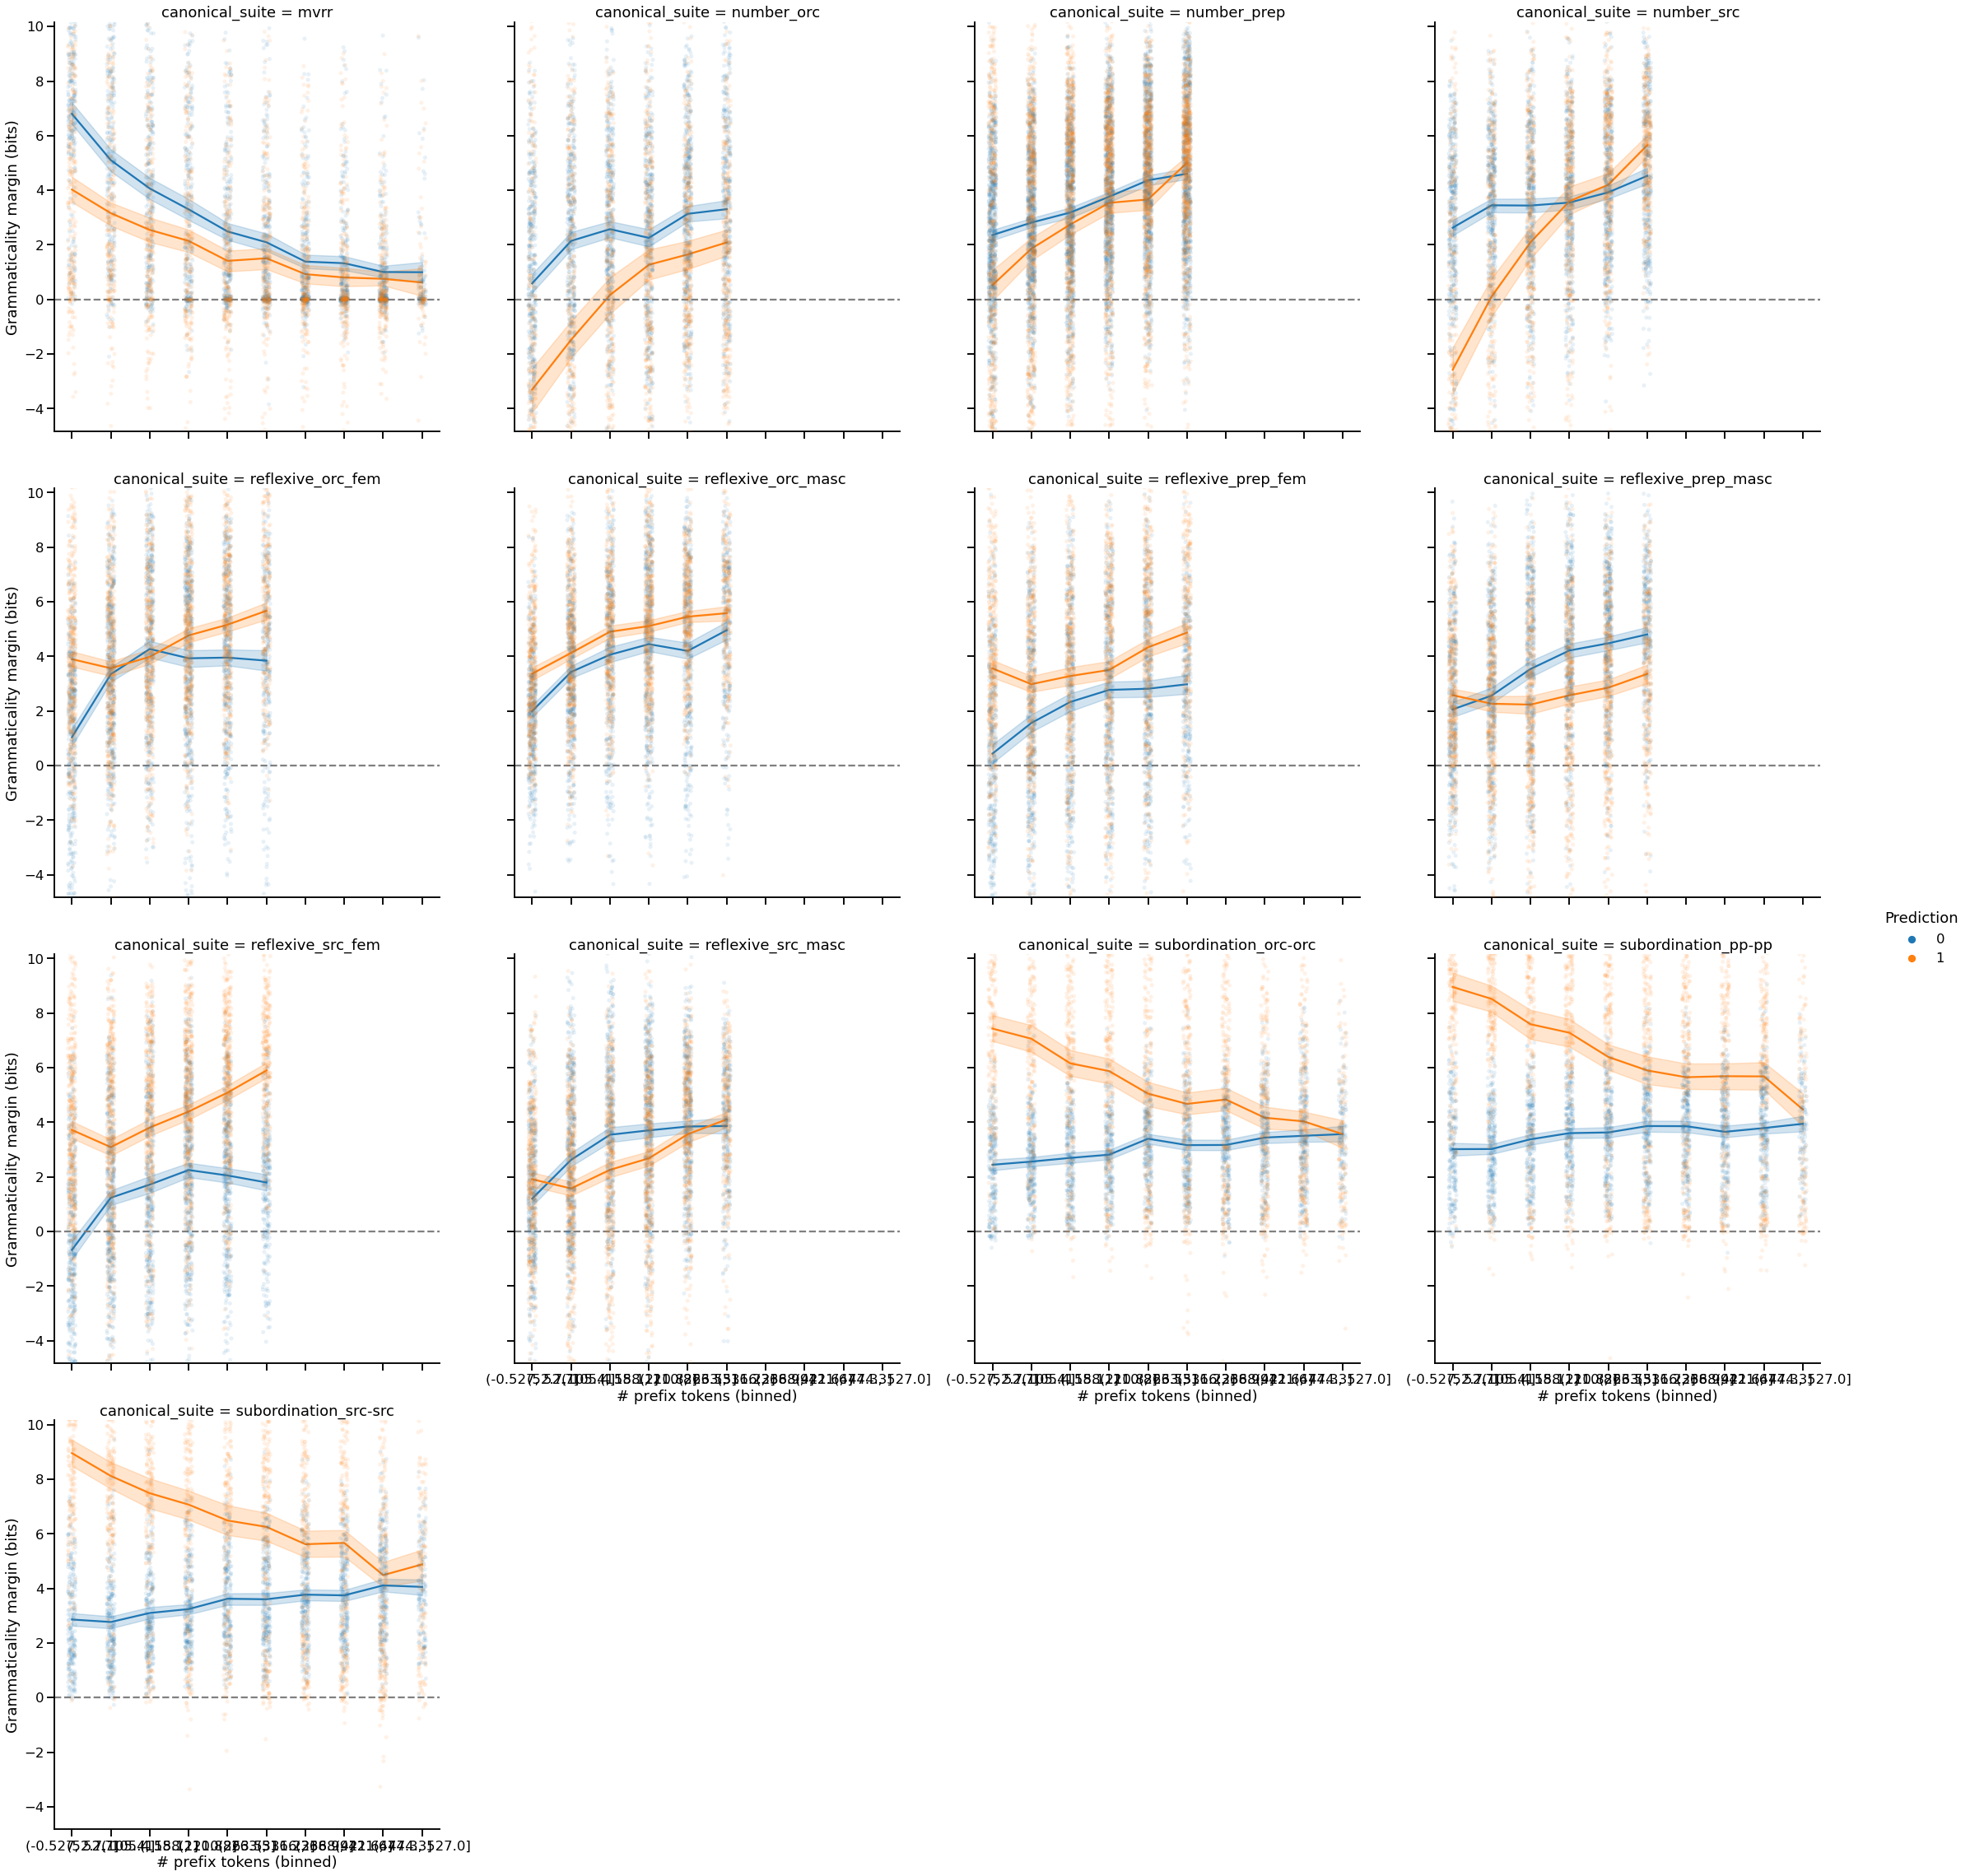

In [62]:
margin_sizes["prefix_length_bin"] = pd.cut(margin_sizes.prefix_length, 10).astype(str)
to_plot = margin_sizes.melt(id_vars=meta_vars,
                            value_vars=[0, 1], var_name="Prediction")
g = sns.catplot(data=to_plot, col="canonical_suite", col_wrap=4,
                x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

for ax in g.axes.flat:
    ax.axhline(0, color="gray", linestyle="--")
    ax.set_xticks(ax.get_xticks(), rotation=35)
    ax.set_xlabel("# prefix tokens (binned)")
    ax.set_ylabel("Grammaticality margin (bits)")

In [72]:
# DEV recompute predictions as a sanity check
recompute_preds = margin_sizes.assign(**{f"correct_{idx}": margin_sizes[idx] > 0
                                         for idx in [col for col in margin_sizes.columns if isinstance(col, int)]})

<AxesSubplot:xlabel='prefix_length_bin', ylabel='value'>

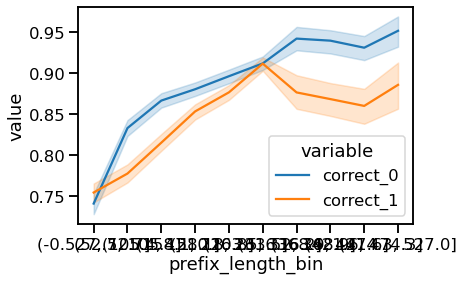

In [75]:
sns.lineplot(data=recompute_preds[["prefix_length_bin", "correct_0", "correct_1"]].melt(id_vars=["prefix_length_bin"]),
             x="prefix_length_bin", y="value", hue="variable")

In [76]:
# recompute_preds[recompute_preds.prefix_length == 0].groupby("canonical_suite").correct.mean()
recompute_preds[recompute_preds.prefix_length == 0][["correct_0", "correct_1"]].melt().groupby("variable").value.mean()

variable
correct_0    0.753731
correct_1    0.854478
Name: value, dtype: float64

## Total probability margins

In [79]:
total_surprisals = region_df.groupby(["suite", "canonical_suite", "item_number", "condition"]).value.sum().reset_index()
total_surprisals

suite        canonical_suite  item_number  \
0                        mvrr                   mvrr            1   
1                        mvrr                   mvrr            1   
2                        mvrr                   mvrr            1   
3                        mvrr                   mvrr            1   
4                        mvrr                   mvrr            2   
...                       ...                    ...          ...   
137927  subordination_src-src  subordination_src-src         2447   
137928  subordination_src-src  subordination_src-src         2448   
137929  subordination_src-src  subordination_src-src         2448   
137930  subordination_src-src  subordination_src-src         2448   
137931  subordination_src-src  subordination_src-src         2448   

                condition        value  
0           reduced_ambig    83.563136  
1         reduced_unambig    86.281953  
2         unreduced_ambig    92.538917  
3       unreduced_unambig    87.930577  
4           reduced_ambig    83.232671  
...                   ...          ...  
137927      sub_no-matrix  2413.919429  
137928      no-sub_matrix  2494.311867  
137929   no-sub_no-matrix  2462.138893  
137930         sub_matrix  2496.571949  
137931      sub_no-matrix  2473.602521  

[137932 rows x 5 columns]

In [80]:
def compute_margins(rows):
    margin_spec = margin_measures[rows.iloc[0].canonical_suite]
    rows = rows.set_index(["condition"]).value
    return pd.Series([rows.loc[ungrammatical_cond] - rows.loc[grammatical_cond]
                      for (_, grammatical_cond), (_, ungrammatical_cond) in margin_spec])

total_surprisal_margins = total_surprisals.groupby(["suite", "item_number"]).apply(compute_margins)
total_surprisal_margins

0         1
suite                 item_number                     
mvrr                  1            -8.975780 -2.718817
                      2            -3.305226  2.797184
                      3            -2.273730  2.796000
                      4             2.511395  2.983787
                      5            -1.691624  0.000000
...                                      ...       ...
subordination_src-src 2444          8.835566 -2.192711
                      2445         12.073153 -1.387066
                      2446          7.068299  2.728880
                      2447          8.012713  4.367473
                      2448         11.463628 -2.260082

[34483 rows x 2 columns]

In [81]:
# Bring back metadata
total_surprisal_margins = pd.merge(total_surprisal_margins.reset_index(), prediction_df[meta_vars].reset_index(),
                                   on=["suite", "item_number"])

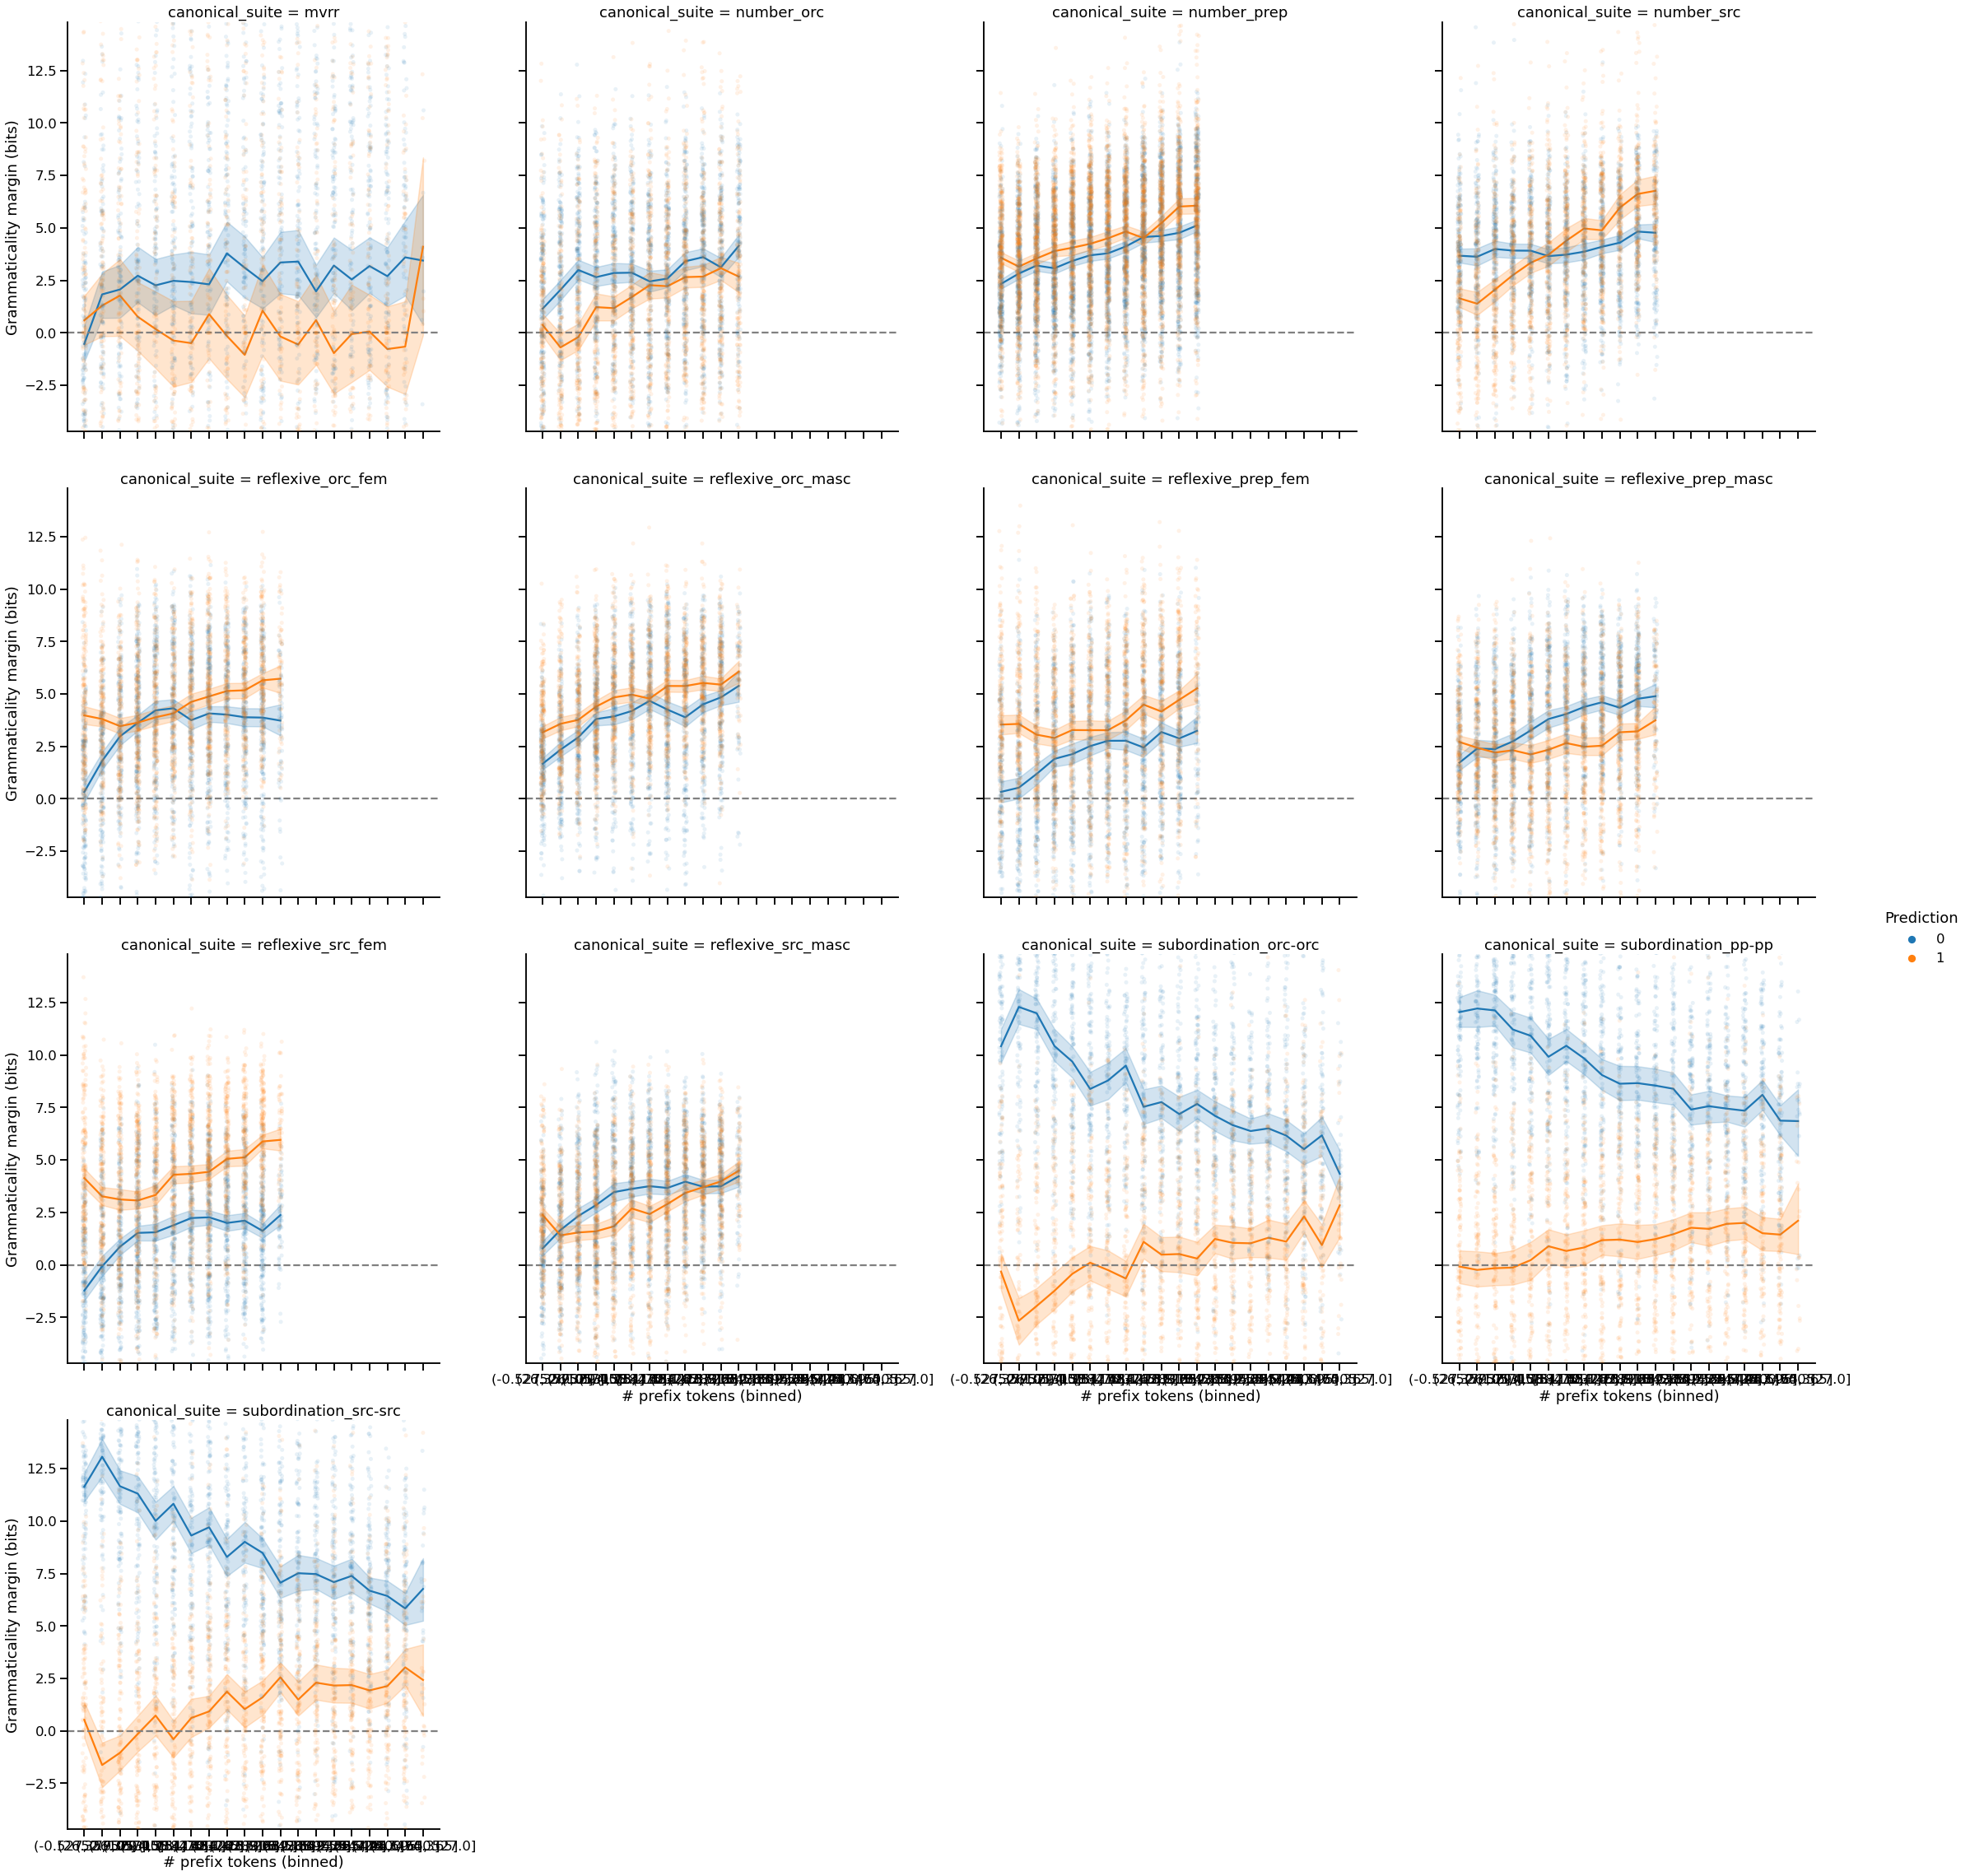

In [82]:
to_plot = total_surprisal_margins.melt(id_vars=["prefix_length_bin", "canonical_suite"],
                                       value_vars=[0, 1], var_name="Prediction")
g = sns.catplot(data=to_plot, col="canonical_suite", col_wrap=4,
                x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=8)
g.map(sns.lineplot, "prefix_length_bin", "value", "Prediction")

for ax in g.axes.flat:
    ax.axhline(0, color="gray", linestyle="--")
    ax.set_xticks(ax.get_xticks(), rotation=35)
    ax.set_xlabel("# prefix tokens (binned)")
    ax.set_ylabel("Grammaticality margin (bits)")